In [1]:
%load_ext autoreload
%autoreload 2

%autosave 10

Autosaving every 10 seconds


In [2]:
import sys
sys.path.append('../') # Make code in "tools" folder visible to python interpreter

import os
import warnings

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_palette("Set2")
%matplotlib widget

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    }
)

from matplotlib.colors import ListedColormap

#plt.rcParams["image.cmap"] = ListedColormap(sns.color_palette(as_cmap=True))

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from tools.data_generation import DataGenerator
from tools.utils import Dataset
from tools.svm import SVMClassifier
from tools.nn_training import Module, ModuleAR

In [3]:
Fs = 2048

# Generate data:


In [45]:
beta_gamma_cfg = {
    "betas": None,
    "gammas": None,
    "beta_sharpness": [0.1, 0.9],
    "phase": None,
    "pac": None,
    "cross_pac": None,
    "phase_shift": None,
    "burst_length": None,
}

In [46]:
data = DataGenerator(beta_gamma_cfg, 0.5, Fs=Fs, T=1200)
dataset = Dataset(data.signal, data.label, Fs, tf_transform=True, ar_len = 10, window_length = 0.5, hop_size = 0.35, fold_id=4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished


Text(0.5, 0, 'Time [samples]')

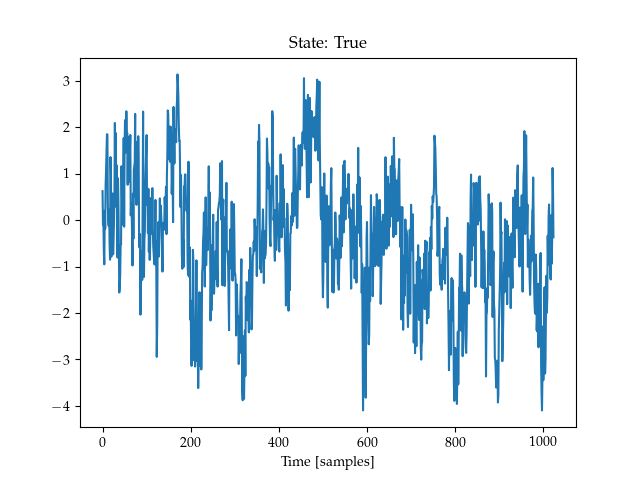

In [24]:
fig, ax = plt.subplots()
ix = 60
x_train = dataset.X_train[ix]

ax.plot(x_train.squeeze())
ax.set_title(f"State: {dataset.y_train[ix]}")
ax.set_xlabel("Time [samples]")


Text(0, 0.5, 'Freq [Hz]')

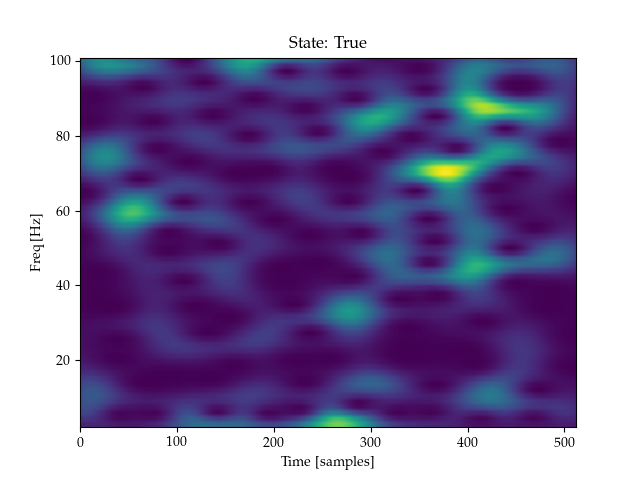

In [7]:
fig, ax = plt.subplots()
x_train = dataset.X_train[ix]

ax.imshow(
    dataset.X_tf_train[ix].squeeze(),
    cmap="viridis",
    aspect="auto",
    origin="lower",
    extent=(0, 512, 2, 101),
)
ax.set_title(f"State: {dataset.y_train[ix]}")
ax.set_xlabel("Time [samples]")
ax.set_ylabel("Freq [Hz]")


# Classify:


### SVM:

In [47]:
cls = SVMClassifier(
        dataset.X_features_train_scaled,
        dataset.X_features_valid_scaled,
        dataset.y_train,
        dataset.y_valid,
    )

cls.classify()

(0.9809694547234313, 0.5096063730084348)

In [48]:
def score_module(module, train_dataloader, valid_dataloader, accelerator='gpu', device=[0]):

    trainer = pl.Trainer(
        logger=True,
        accelerator=accelerator,
        devices=device,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                mode="max",
                monitor="valid/bal_acc",
                save_top_k=1,
            )
        ],
        max_epochs=150,
    )
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="y_pred contains classes not in y_true"
        )
        trainer.fit(module, train_dataloader, valid_dataloader)
        module = module.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        train_score = trainer.validate(module, train_dataloader)[0]["valid/bal_acc"]
        valid_score = trainer.validate(module, valid_dataloader)[0]["valid/bal_acc"]

    return train_score, valid_score


In [49]:
module = Module.with_defaults_1d(1)

score_module(module, dataset.train_dataloader(), dataset.valid_dataloader())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | CNN1d             | 183 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.733     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/fernando/anaconda3/envs/synthetic_data_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/fernando/anaconda3/envs/synthetic_data_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/fernando/anaconda3/envs/synthetic_data_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The n

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/fernando/anaconda3/envs/synthetic_data_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/fernando/anaconda3/envs/synthetic_data_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      valid/bal_acc          0.778165892210426
       valid/loss           0.4246431887149811
       valid/score           1.353522703495445
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/fernando/anaconda3/envs/synthetic_data_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      valid/bal_acc         0.5572124206237196
       valid/loss           0.7812964916229248
       valid/score          0.7759159290007948
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


(0.778165892210426, 0.5572124206237196)

In [ ]:
module = Module(
    "cnn1d", 
    {"n_channels": n_in, }, 
    "Adam", 
    {"lr": 1e-3, "weight_decay": 1e-4}
)